# Advanced Execution with Classiq

This tutorial introduces the `ExecutionSession` class, which simplifies executing a quantum program with two dynamically adjustable parameters. It eliminates the need to re-synthesize the quantum model, streamlining the workflow in the SDK.

**Operations:**

- Sample: Performs projective quantum state measurement for given parameter values.
- Estimate: Calculates a specified operator's expectation value and variance for the quantum state based on the quantum program.

Both operations support:

- Single parameter set or batch mode: Execute with a single set of parameters or multiple sets in one execution.
- Submit mode (with/without): Enables job submission with an ID number to retrieve the job later. Useful for long executions or executions involving waiting lists (typically on hardware).

This tutorial is specifically designed for users of the SDK.

## Sample

Starting with simple example, preparing state in the $|+\rangle$ by applying `H` gate on an initialized qubit.

In [1]:
from classiq import *
from classiq.execution import ExecutionSession


@qfunc
def main(x: Output[QBit], t: CReal):
    allocate(1, x)
    H(x)

After creating a quantum model and synthesizing it, the next step is defining an `ExecutionSession` of the quantum program, a reusable object that allows you to re-execute without re-synthesize.

In [2]:
qmod = create_model(main)
qprog_non_parametric = synthesize(qmod)

execution_session_non_parametric = ExecutionSession(qprog_non_parametric)

Apply `sample` to measure the qubit:

In [3]:
res = execution_session_non_parametric.sample()

Now, `res` contains information on the execution, such as `parsed_counts`, `num_shots`, and other execution parameters. Some of these could be set in advance using `ExecutionPreferences`, and others are result-related.

In [4]:
print(res)

vendor_format_result={} counts={'0': 1042, '1': 1006} counts_lsb_right=True probabilities={} parsed_states={'0': {'x': 0}, '1': {'x': 1}} histogram=None output_qubits_map={'x': (0,)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'x': (0,)} num_shots=2048


Usually, the most interesting one is the `parsed_counts` parameter:

In [5]:
res.parsed_counts

[{'x': 0}: 1042, {'x': 1}: 1006]

Since we started from the plus state, $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$, it is not surprising that we received approximately half of the counts for each of the computational basis unit vectors.

## Batch Sample

When handling **parametric circuits**, using `ExecutionSession` is especially handy. \
Starting with defining a new `ExecutionSession`for a simple parametric circuit:

In [6]:
@qfunc
def main(x: Output[QBit], t: CReal, w: CReal):
    allocate(1, x)
    RX(t, x)
    RZ(w, x)


qmod = create_model(main)
qprog = synthesize(qmod)

execution_session = ExecutionSession(qprog)

Using `sample` with a set of parameters:

In [7]:
sample_result = execution_session.sample({"t": 0.5, "w": 0.7})

In [8]:
print(sample_result.parsed_counts)

[{'x': 0}: 1931, {'x': 1}: 117]


Using `batch_sample` is handy when having a multiple values for each of the parameters:

In [9]:
from numpy import pi

batch_sample_result = execution_session.batch_sample(
    [{"t": 0.5 * pi, "w": pi}, {"t": pi, "w": 0.5 * pi}]
)

Accessing the `parsed_counts` of each set of values is easy by using:

In [10]:
for item in batch_sample_result:
    print(item.parsed_counts)

[{'x': 0}: 1039, {'x': 1}: 1009]
[{'x': 1}: 2048]


Now, assuming the execution is set to run on a specific hardware in advance using `ExecutionPreferences`, the executed job might wait in line for execution depending on the load on the specific hardware. \
For this case, using `submit_sample` (single set of parameters), or `submit_batch_sample` (multiple set of parameters) helps retrieve the job using its job `id`.

<details> 
<summary>Note on `execute()`</summary>

The function [`execute()`](https://docs.classiq.io/latest/classiq_101/classiq_concepts/execute/), which is used on the last page, is actually an equivalent shortcut to:

```python
execution_session.submit_sample()
```
</details> 

In [11]:
batch_sample_job = execution_session.submit_batch_sample(
    [{"t": 0.5 * pi, "w": pi}, {"t": pi, "w": 0.5 * pi}]
)

In [12]:
job_id = batch_sample_job.id
print(job_id)

2877346b-d6ad-4884-b2f8-a13afa0ce668


Retaining the job `id` string allows you to retrieve execution results even if you close your Python environment and return to it later. This feature is especially useful when running on real QPUs or emulating large quantum programs, where execution may involve long wait times or interruptions.

In [13]:
from classiq.execution import ExecutionJob

retrieved_job = ExecutionJob.from_id(job_id)
print(retrieved_job.get_batch_sample_result())

[ExecutionDetails(vendor_format_result={}, counts={'1': 1009, '0': 1039}, counts_lsb_right=True, probabilities={}, parsed_states={'1': {'x': 1}, '0': {'x': 0}}, histogram=None, output_qubits_map={'x': (0,)}, state_vector=None, parsed_state_vector_states=None, physical_qubits_map={'x': (0,)}, num_shots=2048), ExecutionDetails(vendor_format_result={}, counts={'1': 2048}, counts_lsb_right=True, probabilities={}, parsed_states={'1': {'x': 1}}, histogram=None, output_qubits_map={'x': (0,)}, state_vector=None, parsed_state_vector_states=None, physical_qubits_map={'x': (0,)}, num_shots=2048)]


Or specifcally the `parsed_counts`:

In [14]:
for item in retrieved_job.get_batch_sample_result():
    print(item.parsed_counts)

[{'x': 0}: 1039, {'x': 1}: 1009]
[{'x': 1}: 2048]


<details>
<summary>Note on Non-Commutative Rotations</summary>

In quantum mechanics, rotations applied to qubits generally **do not commute**, meaning the order of rotations like `RX` and `RZ` affects the qubit's final state.

**Why Different Results?**

Applying `RX(0.5 * π)` then `RZ(π)` yields a different result than `RX(π)` followed by `RZ(0.5 * π)`. This is due to the non-commutative nature of rotations around different axes:
$$
RX(\theta_1) \cdot RZ(\theta_2) \neq RZ(\theta_2) \cdot RX(\theta_1)
$$
Rotations around the X-axis (`RX`) and Z-axis (`RZ`) move the qubit to different points on the Bloch sphere, so changing the rotation order changes the final state and measurement outcomes.

This non-commutativity in rotations leads to different measurement distributions in our batch sampling.

</details>

The same concepts apply to estimate, which calculates the expectation value of an operator for a given quantum state, represented by the quantum program. This can be performed for a specific operator, either as a single job or in batch mode, with or without using submit.

In [15]:
write_qmod(qmod, "advanced_execution_user_guide")

## Estimate

The `estimate()` operation calculates the expectation value:

$$
\langle \psi | H | \psi \rangle
$$

where $|\psi\rangle$ is the quantum state the quantum program represents, and $H$ is the Hamiltonian— the operator whose expectation value is being determined.

<details>
<summary>Expectation Value - Mathematical Elaboration</summary>

\
In the general case:

$$
|\psi\rangle = \sum_{i=1}^N \alpha_i |i\rangle,
$$

where $|i\rangle$ are the basis states (typically computational basis states), $\alpha_i$ are the complex coefficients satisfying the normalization condition $\sum_{i=1}^N |\alpha_i|^2 = 1$.

The expectation value of the Hamiltonian $H$ is calculated as:

$$
\langle \psi | H | \psi \rangle = \left( \sum_{i=1}^N \alpha_i^* \langle i | \right) H \left( \sum_{j=1}^N \alpha_j |j\rangle \right),
$$

where $\alpha_i^*$ is the complex conjugate of $\alpha_i$. Expanding this expression:

$$
\langle \psi | H | \psi \rangle = \sum_{i=1}^N \sum_{j=1}^N \alpha_i^* \alpha_j \langle i | H | j \rangle.
$$

Here, $\langle i | H | j \rangle$ represents the matrix elements of the Hamiltonian in the chosen basis. 

\
In quantum computing, the Hamiltonian $H$ is often expressed as a linear combination of Pauli operators:

$$
H = \sum_k c_k P_k,
$$

where $c_k$ are real coefficients, and $P_k$ are Pauli operators (e.g., $I$, $X$, $Y$, $Z$, or tensor products of these). The expectation value becomes:

$$
\langle \psi | H | \psi \rangle = \sum_k c_k \langle \psi | P_k | \psi \rangle.
$$

Each term $\langle \psi | P_k | \psi \rangle$ corresponds to the expectation value of a Pauli operator $P_k$, which can be obtained by measuring the state $|\psi\rangle$ in the basis of $P_k$. 

\
**Non-Commutativity of Paulis:**  
If the Pauli operators $P_k$ do not commute, separate measurements are required for each $P_k$. This is because measurement in one basis collapses the quantum state, preventing subsequent measurement in a non-commuting basis. Thus, the expectation value of $H$ involves multiple measurements, with each term $\langle \psi | P_k | \psi \rangle$ requiring its own basis alignment.

This approach is crucial for estimating the expectation value of $H$ when working with quantum states, especially in variational quantum algorithms like VQE.

</details>

Starting again with a simple example, using `execution_session_non_parametric` from the first part, and the following Hamiltonian:

In [16]:
hamiltonian = [
    PauliTerm(pauli=[Pauli.I], coefficient=1),
    PauliTerm(pauli=[Pauli.Z], coefficient=2),
]

In [17]:
execution_session_non_parametric.estimate(hamiltonian)

EstimationResult(value=(1.03515625+0j), metadata=EstimationMetadata(shots=2048, remapped_qubits=False, input_qubit_map=None))

Here, $| \psi \rangle$ is the quantum state defined within the non-parametric quantum program and was stored in `execution_session_non_parametric` at the beginning of the previous section.

Similarly, when $| \psi \rangle$ is a parametric program:

In [18]:
from classiq import *
from classiq.execution import ExecutionSession


@qfunc
def main(x: Output[QBit], t: CReal):
    allocate(1, x)
    RX(t, x)


qmod = create_model(main)
qprog = synthesize(qmod)

execution_session = ExecutionSession(qprog)

Now, simply call estimate with a single set of parameters:

In [19]:
estimate_result = execution_session.estimate(hamiltonian, {"t": 0.5})
estimate_result

EstimationResult(value=(2.7578125+0j), metadata=EstimationMetadata(shots=2048, remapped_qubits=False, input_qubit_map=None))

It contains the `value` and the `variance` of the expectation value, as well as the `metadata` of the execution. \
In this example, the expectation value is:

In [27]:
estimate_result.value
estimate_result

EstimationResult(value=(2.7578125+0j), metadata=EstimationMetadata(shots=2048, remapped_qubits=False, input_qubit_map=None))

Similarly to `sample`, it is possible to execute a batch of parameters with `estimate`. \
For instance:

In [21]:
from numpy import pi

batch_estimate_result = execution_session.batch_estimate(
    hamiltonian,
    [{"t": 0 * pi}, {"t": 0.5 * pi}, {"t": 1 * pi}, {"t": 1.5 * pi}, {"t": 2 * pi}],
)

Again, `batch_estimate_result` contains a list of results that could be accessed by using a `for` loop:

In [22]:
for E in batch_estimate_result:
    print(E.value)

(3+0j)
(0.9609375+0j)
(-1+0j)
(0.9140625+0j)
(3+0j)


Lastly, it demonstrates how one might loop over a large set of parameters. It could be useful in many cases of [Hamiltomian simulation](https://docs.classiq.io/latest/user-guide/read/hamiltonian_simulation_guide/). \
Here, it is used to find the value of theta in `theta_list` that minimizes the energy:

Or in an automated manner to create a larger batch:

In [23]:
import numpy as np

# Generate 100 linearly spaced values for t from 0 to 2*pi
theta_list = np.linspace(0, 2 * pi, 100)

# Create the list of dictionaries for batch sampling
batch_sample = [{"t": t} for t in theta_list]

# Execute batch estimate
batch_estimate_result = execution_session.batch_estimate(hamiltonian, batch_sample)

For a hundred items, it will be better to plot the results in a graph:

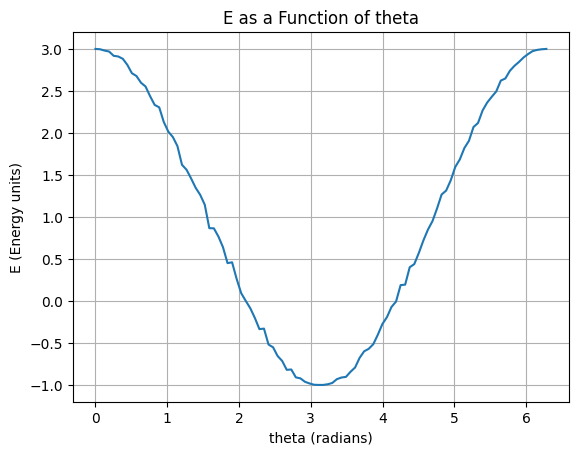

In [24]:
import matplotlib.pyplot as plt

# Extract values of E and t
E_values = [np.real(E.value) for E in batch_estimate_result]
theta_values = [sample["t"] for sample in batch_sample]

# Plot E as a function of t
plt.plot(theta_list, E_values)
plt.xlabel("theta (radians)")
plt.ylabel("E (Energy units)")
plt.title("E as a Function of theta")
plt.grid(True)  # Add grid for better visualization
plt.show()

In [25]:
print("The number of different energies:", len(E_values))
print("The minimal energy is:", min(E_values))

The number of different energies: 100
The minimal energy is: -0.998046875


Using `.submit_estimate()` and `submit_batch_estimate()` is useful for long executions and real hardware execution, allowing results to be retrieved later using the job's `id` for single or multiple sets of execution parameters, respectively.

<details>
<summary>Practice</summary>

**Fundamental Practice:**

Verify your understanding by repeating what was done in the **Sample** section but using `.submit_estimate()` and `submit_batch_estimate()`.

**Advanced Practice:**

Use one of the `estimate` options to implement the [VQE](https://docs.classiq.io/latest/user-guide/read/qml_with_classiq_guide/#using-the-vqe-primitive) algorithm yourself.

</details>

## Read More

- User Guide:
    - [`ExecutionSession`]((https://docs.classiq.io/latest/user-guide/executor/ExecutionSession/))
    - [`ExecutionJob`](https://docs.classiq.io/latest/sdk-reference/#classiq.execution.jobs.ExecutionJob)
- Examples:
    - [Hamiltomian Simulation](https://docs.classiq.io/latest/user-guide/read/hamiltonian_simulation_guide/)
    - [Variational Quantum Linear Solver (VQLS)](https://docs.classiq.io/latest/explore/algorithms/vqls/lcu_vqls/vqls_with_lcu/?h=vql)